In [2]:
import osiris_utils as ou
import numpy as np
from pathlib import Path
from tqdm import tqdm
import h5py
import sys
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import RegularGridInterpolator
from tqdm import tqdm
from scipy.signal import savgol_filter
import pandas as pd

from scipy.stats import linregress
from scipy.interpolate import RegularGridInterpolator
from matplotlib.ticker import FuncFormatter, MaxNLocator, FixedLocator,  FormatStrFormatter
from scipy import optimize
from mpl_toolkits.mplot3d import Axes3D

import contextlib
import io
import math

plt.rcParams['font.size'] = 14

In [3]:
def createSimDic(sim_labels, test):
    sim = {}
    for key in sim_labels.keys():
        sim[key] = {}
        for dtw in sim_labels[key]:
            sim[key][dtw] = ou.Simulation(f"/home/exxxx5/Tese/Decks/weibelTestsFinal/{test}/{key}/dtw{dtw}/{key}.in")
    return sim


def round_size(n):
    """Round n to 1 significant digit."""
    if n == 0:
        return 0
    return round(n, -int(math.floor(math.log10(n))))

def mean_rel_err_with_ar1(e):
    e = np.asarray(e)              # 1) Ensure e is a NumPy array (vector ops, speed, safety).
    N = e.size                     # 2) Number of time samples.

    if N < 2:                      # 3) If we have <2 points, we can't estimate variability.
        return float(e.mean()), np.nan

    em = e.mean()                  # 4) Sample mean: this is the point you will plot.
    x = e - em                     # 5) Mean-center the series (needed for variance & autocorr).
    s2 = x.var(ddof=1)             # 6) Sample variance of e_t (unbiased: ddof=1).

    # 7) Lag-1 autocorrelation ρ(1): similarity between consecutive samples.
    #    num = Σ (x_t * x_{t-1}); den = Σ (x_t^2). ρ(1) = num/den.
    num = np.dot(x[1:], x[:-1])
    den = np.dot(x, x)
    if (den == 0 or N < 3):
        rho1 = 0.0                 #    If constant or too short, assume no autocorrelation.
    else:
        rho1 = np.clip(num / den, -0.99, 0.99)  #    Clip for numerical stability.

    # 8) Effective sample size Neff for AR(1)-like correlation:
    #    With positive ρ(1), neighboring points carry redundant info, so Neff < N.
    Neff = N * (1 - rho1) / (1 + rho1)
    Neff = float(np.clip(Neff, 1.0, N))   #    Keep in [1, N] to avoid pathologies.

    # 9) Standard error of the mean using Neff (not naive N):
    #    SE( ē ) ≈ sqrt( s^2 / Neff ).
    se = np.sqrt(s2 / Neff)

    return float(em), float(se)

def find_nans_2d(a: np.ndarray):
    """
    Return locations and summary of NaNs in a 2D array.

    Returns dict with:
      - mask: boolean array, True where NaN
      - coords: (k,2) int array of [row, col] indices
      - rows: unique row indices containing NaN
      - cols: unique col indices containing NaN
      - count: total number of NaNs
    """
    a = np.asarray(a)
    if a.ndim != 2:
        raise ValueError("Input must be 2D")

    mask = np.isnan(a)
    count = int(mask.sum())
    if count:
        coords = np.argwhere(mask)
        rows = np.unique(coords[:, 0])
        cols = np.unique(coords[:, 1])
    else:
        coords = np.empty((0, 2), dtype=int)
        rows = np.array([], dtype=int)
        cols = np.array([], dtype=int)

    return dict(mask=mask, coords=coords, rows=rows, cols=cols, count=count)

In [4]:
def check_out_bounds(track):
    """
    Return rows of `track` that are outside the grid and a boolean flag
    indicating whether at least one particle is out of bounds.
    """
    mask = ((track['x1'] < track.grid[0, 0]) | (track['x1'] > track.grid[0, 1]) |
            (track['x2'] < track.grid[1, 0]) | (track['x2'] > track.grid[1, 1]) |
            (track['x3'] < track.grid[2, 0]) | (track['x3'] > track.grid[2, 1]))

    has_oob = bool(mask.any())
    return has_oob

In [5]:
def call_silently(func, *args, **kwargs):
    with contextlib.redirect_stdout(io.StringIO()):
        return func(*args, **kwargs)


def get_trajectory(sim, particle, tmin = 0, tmax = 100000000000, unload=False):
    track = sim["test_electrons"]["tracks"]
    track.load_all()

    mask = (track.data["t"][particle, :] >= tmin) & (track.data["t"][particle, :] <= tmax)
    traj = np.stack([
        track.data["x1"][particle, :][mask],
        track.data["x2"][particle, :][mask],
        track.data["x3"][particle, :][mask],
        track.data["t"][particle, :][mask]
        ], axis=0)

    if unload:
        track.unload()

    return traj

def plot_trajectory(sim, label, particle, tmin = 0, tmax = 100000000000, markersize=1.8, color = None, linewidth=0.8, linestyle='-', unload=False, fig=None, ax=None):
    traj = call_silently(get_trajectory, sim, particle, tmin, tmax)

    x, y, z, t = traj[0, :], traj[1, :], traj[2, :], traj[3, :]
    
    if fig is None:
        fig = plt.figure(figsize=(10, 7))

    label1 = None
    label2 = None
    if ax is None:
        ax = fig.add_subplot(111, projection='3d')
        label1 = ("$t = {:.3f}$".format(t[0]) + "$[{}]$".format(sim["test_electrons"]["tracks"].units["t"]))
        label2 = ("$t = {:.3f}$".format(t[-1]) + "$[{}]$".format(sim["test_electrons"]["tracks"].units["t"]))
    
    # Highlight start and end points
    ax.scatter(x[0], y[0], z[0], color='lightgreen', s=20, label=label1)
    ax.scatter(x[-1], y[-1], z[-1], color='r', s=20, label=label2)

    # Plot the trajectory
    ax.plot(x, y, z, marker='o', linestyle=linestyle, markersize=markersize, linewidth=linewidth, label=label, color=color)
    
    # Labels and title
    ax.set_xlabel('${}$'.format(sim["test_electrons"]["tracks"].labels["x1"]) + "$[{}]$".format(sim["test_electrons"]["tracks"].units["x1"]))
    ax.set_ylabel('${}$'.format(sim["test_electrons"]["tracks"].labels["x2"]) + "$[{}]$".format(sim["test_electrons"]["tracks"].units["x2"]))
    ax.set_zlabel('${}$'.format(sim["test_electrons"]["tracks"].labels["x3"]) + "$[{}]$".format(sim["test_electrons"]["tracks"].units["x3"]))
    ax.legend()

    return fig, ax

In [6]:
def call_silently(func, *args, **kwargs):
    with contextlib.redirect_stdout(io.StringIO()):
        return func(*args, **kwargs)


def get_trajectory(sim, particle, tmin = 0, tmax = 100000000000, unload=False):
    track = sim["test_electrons"]["tracks"]
    track.load_all()

    mask = (track.data["t"][particle, :] >= tmin) & (track.data["t"][particle, :] <= tmax)
    traj = np.stack([
        track.data["x1"][particle, :][mask],
        track.data["x2"][particle, :][mask],
        track.data["x3"][particle, :][mask],
        track.data["t"][particle, :][mask]
        ], axis=0)

    if unload:
        track.unload()

    return traj

def get_p(sim, particle, tmin = 0, tmax = 100000000000, unload=False):
    track = sim["test_electrons"]["tracks"]
    track.load_all()

    mask = (track.data["t"][particle, :] >= tmin) & (track.data["t"][particle, :] <= tmax)
    traj = np.stack([
        track.data["p1"][particle, :][mask],
        track.data["p2"][particle, :][mask],
        track.data["p3"][particle, :][mask],
        track.data["t"][particle, :][mask]
        ], axis=0)

    if unload:
        track.unload()

    return traj


def get_fields(sim, particle, tmin = 0, tmax = 100000000000, unload=False):
    track = sim["test_electrons"]["tracks"]
    track.load_all()

    mask = (track.data["t"][particle, :] >= tmin) & (track.data["t"][particle, :] <= tmax)
    traj = np.stack([
        track.data["E1"][particle, :][mask],
        track.data["E2"][particle, :][mask],
        track.data["E3"][particle, :][mask],
        track.data["B1"][particle, :][mask],
        track.data["B2"][particle, :][mask],
        track.data["B3"][particle, :][mask],
        track.data["t"][particle, :][mask]
        ], axis=0)

    if unload:
        track.unload()

    return traj

def get_gradB(sim, t=None):
    
    # Grid centered simulation
    sim_centered = ou.FieldCentering_Simulation(sim)

    B = (sim_centered["part_b1"]**2 + sim_centered["part_b2"]**2 + sim_centered["part_b3"]**2)**(0.5)

    dB_x1 = ou.Derivative_Diagnostic(B, "x1")
    dB_x2 = ou.Derivative_Diagnostic(B, "x2")
    dB_x3 = ou.Derivative_Diagnostic(B, "x3")
    
    if isinstance(t, int):
        return np.stack([
            dB_x1[t],
            dB_x2[t],
            dB_x3[t]
        ], axis=0)
    else:
        return np.stack([
            dB_x1,
            dB_x2,
            dB_x3
        ], axis=0)

def get_b(sim, t=None):
    # Grid centered simulation
    sim_centered = ou.FieldCentering_Simulation(sim)

    B = (sim_centered["part_b1"]**2 + sim_centered["part_b2"]**2 + sim_centered["part_b3"]**2)**(0.5)

    b1 = sim_centered["part_b1"] / B
    b2 = sim_centered["part_b2"] / B
    b3 = sim_centered["part_b3"] / B

    b = np.stack([b1, b2, b3], axis=0)

    if isinstance(t, int):
        return b[t]
    else:
        return b
    
def get_Jacobian_b(sim, t=None):
    
    # Grid centered simulation
    sim_centered = ou.FieldCentering_Simulation(sim)

    B = (sim_centered["part_b1"]**2 + sim_centered["part_b2"]**2 + sim_centered["part_b3"]**2)**(0.5)

    b1 = sim_centered["part_b1"] / B
    b2 = sim_centered["part_b2"] / B
    b3 = sim_centered["part_b3"] / B

    J_B = np.empty((3, 3), dtype=object)
    for i, b_buffer in enumerate([b1, b2, b3]):
        for j, axis in enumerate(["x1", "x2", "x3"]):
            J_B[i,j] = ou.Derivative_Diagnostic(b_buffer, axis)

    if isinstance(t, int):
        return J_B[:, :, t]
    else:
        return J_B


def get_Jacobian_b_Interp(J_B, t=None):
    vfunc = np.vectorize(diag_interpolator, otypes=[object])
    return vfunc(J_B, t=t)


def diag_interpolator(diag, t=0):
    # TODO maybe considder periodic boundaries
    
    # Define grid points
    x = np.linspace(diag.grid[0][0] + diag.dx[0] / 2., diag.grid[0][1] - diag.dx[0] / 2., diag.nx[0])
    y = np.linspace(diag.grid[1][0] + diag.dx[1] / 2., diag.grid[1][1] - diag.dx[1] / 2., diag.nx[1])
    z = np.linspace(diag.grid[2][0] + diag.dx[2] / 2., diag.grid[2][1] - diag.dx[2] / 2., diag.nx[2])

    # return RegularGridInterpolator((x, y, z), diag[t], bounds_error=False, fill_value=None, method='cubic')
    return RegularGridInterpolator((x, y, z), diag[t], bounds_error=False, fill_value=None, method='linear')


def get_p_drift_savgol(p_perp, B, dt, n):
    Lfloat = 2. * np.pi / (B * dt) * n
    Lodd = (Lfloat.round().astype(int) // 2) * 2 + 1
    Lodd[Lodd < 5] = 5

    p_drift = np.empty_like(p_perp)

    breaks = np.flatnonzero(np.diff(Lodd)) + 1
    segments = np.concatenate(([0], breaks, [np.shape(p_perp)[1]]))

    for i0, i1 in zip(segments[:-1], segments[1:]):
        L = int(Lodd[i0])
        for comp in range(3):
            # Ensure window length does not exceed segment length
            window_length = min(L, i1 - i0)
            # Ensure polyorder is less than window_length
            polyorder = min(1, window_length - 1)  # polyorder should be less than window_length
            
            if window_length >= 3:  # Ensure window length is at least 3
                p_drift[comp, i0:i1] = savgol_filter(
                    p_perp[comp, i0:i1],
                    window_length=window_length,
                    polyorder=polyorder,
                    mode="interp"
                )
            else:
                print("Invalid window length for segment:", i0, i1, " Length:", i1 - i0)
                p_drift[comp, i0:i1] = p_perp[comp, i0:i1]  # Handle too short segment gracefully

    return p_drift


def plot_Ene(sim, label, fig=None, ax=None, unload=False):
    step = 100
    
    sim["test_electrons"]["tracks"].load_all()
    track = sim["test_electrons"]["tracks"]
    t = track["t"][0, ::step]

    if fig is None or ax is None:
        fig, ax = plt.subplots()

    Ene = np.average(track["ene"][:, ::step], axis = 0)
    ax.plot(t, Ene, label=label)
    ax.set_xlabel("${}$".format(track.labels["t"]) + "$[{}]$".format(track.units["t"]))
    ax.set_ylabel("${}$".format(track.labels["ene"]) + "$[{}]$".format(track.units["ene"]))

    if unload:
        track.unload()

    return fig, ax



def plot_drifts(sim, particles, tmin = 0, tmax = 100000000000, unload=False, fig=None, ax=None, n=1, rqm=-1):
    # plots non relativistic gca drifts along time

    gradB=get_gradB(sim)
    interp_gradB_1 = diag_interpolator(gradB[0], t=0)
    interp_gradB_2 = diag_interpolator(gradB[1], t=0)
    interp_gradB_3 = diag_interpolator(gradB[2], t=0)

    J_b = get_Jacobian_b(sim)
    J_b_Interp = get_Jacobian_b_Interp(J_b, t=0)
    
    v_EXB=[]
    v_GradB=[]
    v_c=[]
    v_v_EGrad_B=[]
    v_drif=[]
    v_gyr = []
    v_perp = []
    v_par = []
    v_total = []
    B_total = []
    E_total = []

    for particle in tqdm(particles, desc="Calculating Drifts"):
        # get x, p, E, B, t for the trajecotry of each particle
        fields = call_silently(get_fields, sim, particle, tmin, tmax)
        traj = call_silently(get_trajectory, sim, particle, tmin, tmax)
        p = call_silently(get_p, sim, particle, tmin, tmax)

        E = fields[0:3, :]
        B = fields[3:6, :]
        B_norm = np.linalg.norm(B, axis=0)
        b = B / B_norm
        b_B = b / B_norm
        t = fields[-1, :]
        dt = t[1]-t[0]

        # p parallel to b
        p_par = np.einsum('it, it->t', p[:3], b)
        #I think p is normalized with the mass of the particle so it is the same as u (no need to consider mass)
   
        p_perp = p[:3] - p_par * b
        v_perp.append(np.linalg.norm(p_perp, axis=0))
        v_par.append(np.abs(p_par))
        v_total.append(np.linalg.norm(p[:3], axis=0)) 


        # E x B drift
        v_EXB_vec = np.cross(E.T, b_B.T).T
        v_EXB.append(np.linalg.norm(v_EXB_vec, axis=0))

        

        # # p_perp drift
        # p_perp_drift_list = []
        # p_perp_g_list = []
        # mu_list = []
        
        # for i in range(20*n, len(t)-20*n):
        #     #Calculate B on the point = w_ce0
        #     B0 = np.linalg.norm(B[:, i])

        #     #Number of points in the same gyrocycle
        #     n_points = int(np.ceil(n* 2. * np.pi / (B0  * dt) ))

        #     # Calculate average B in selected points
        #     B_av_before = np.mean(np.linalg.norm(B[:, i-n_points+1 : i+1], axis=0))
        #     B_av_after = np.mean(np.linalg.norm(B[:, i+1 : i+n_points+1], axis=0))

        #     #Calculate better n_points
        #     n_points_before = int(np.ceil(n * 2. * np.pi / (B_av_before  * dt) ))
        #     n_points_after = int(np.ceil(n * 2. * np.pi / (B_av_after  * dt) ))

        #     # Calculate the drift velocity
        #     p_perp_drift = np.mean(p_perp[:, i-n_points_before+1 : i+n_points_after+1], axis=1)

        #     p_perp_g = np.linalg.norm(p_perp[:, i] - p_perp_drift)

        #     # print(n_points_before, n_points_after)
        #     # fig, ax = plt.subplots()
        #     # ax.plot(t[i-n_points_before+1 : i+n_points_after+1], np.linalg.norm(p_perp[:, i-n_points_before+1 : i+n_points_after+1], axis=0), label = "$p_{perp}$", marker='o', linestyle='-', markersize = 1.8, linewidth=1)
        #     # ax.scatter(t[i], np.linalg.norm(p_perp_drift), label="$p_{perp}^{drift}$")
        #     # ax.scatter(t[i], p_perp_g, label="$p_{perp}^{g}$")
        #     # ax.legend()
        #     # return fig, ax
        
        #     mu = p_perp_g**2 / (2. * B0)
        #     mu_list.append(mu)

        #     p_perp_drift_list.append(np.linalg.norm(p_perp_drift))
        #     p_perp_g_list.append(p_perp_g)



        # p_perp drift and p_perp_gyro
        p_perp_drift = get_p_drift_savgol(p_perp,  B_norm, dt, n)
        v_drif.append(np.linalg.norm(p_perp_drift, axis=0))

        p_perp_g = np.linalg.norm(p_perp - p_perp_drift, axis=0)
        mu_list = p_perp_g**2 / (2. * B_norm)
        v_gyr.append(p_perp_g)

        # fig, ax = plt.subplots()
        # # ax.plot(t, p_perp[0], label = r"$p_{\perp 1}$", marker='o', linestyle='-', markersize = 1.8, linewidth=1)
        # ax.plot(t, p_perp[1], label = r"$p_{\perp 2}$", marker='o', linestyle='-', markersize = 1.8, linewidth=1)
        # # ax.plot(t, p_perp[2], label = r"$p_{\perp 3}$", marker='o', linestyle='-', markersize = 1.8, linewidth=1)
        # # ax.plot(t, p_perp_drift[0], label = r"$p^{drift}_{\perp 1}$", marker='o', linestyle='-', markersize = 1.8, linewidth=1)
        # ax.plot(t, p_perp_drift[1], label = r"$p^{drift}_{\perp 2}$", marker='o', linestyle='-', markersize = 1.8, linewidth=1)
        # # ax.plot(t, p_perp_drift[2], label = r"$p^{drift}_{\perp 3}$", marker='o', linestyle='-', markersize = 1.8, linewidth=1)
        # ax.legend()
        # return fig, ax



        # GradB drift
        gradB_traj = np.stack([
            interp_gradB_1(traj[0:3].T),
            interp_gradB_2(traj[0:3].T),
            interp_gradB_3(traj[0:3].T)
        ], axis=0)

        v_GradB.append(np.linalg.norm(np.cross(b_B.T, gradB_traj.T), axis=1) * mu_list)


        # Interpolate jacobian of b
        J_b_traj = np.empty((3, 3, np.shape(t)[0]), dtype=float)
        for i in range(3):
            for j in range(3):
                J_b_traj[i,j] = J_b_Interp[i,j](traj[0:3].T)

        #Curvature drift: (b.Grad)b
        curvature = np.einsum('tj,tij->it', b.T, J_b_traj.transpose(2, 0, 1))

        vc_temp = rqm * (p_par**2)[:,None] * np.cross(b_B.T, curvature.T)
        v_c.append(np.linalg.norm(vc_temp, axis=1))


        # (v_E.Grad)b drift
        v_EGrad_B = np.einsum('tj,tij->it', v_EXB_vec.T, J_b_traj.transpose(2, 0, 1))
        v_v_EGrad_B_temp = rqm * (p_par)[:,None] * np.cross(b_B.T, v_EGrad_B.T)
        v_v_EGrad_B.append(np.linalg.norm(v_v_EGrad_B_temp, axis=1))

        B_total.append(B_norm)
        E_total.append(np.linalg.norm(E, axis=0))



    # fig, ax = plt.subplots(figsize=(10, 7))
    # ax.plot(t[20*n:-20],  np.linalg.norm(p_perp, axis = 0)[20*n:-20*n], label=r"$p_{\perp}$", marker='o', linestyle='-', markersize = 1.8, linewidth=1)
    # ax.plot(t[20*n:-20*n],  np.linalg.norm(p_perp_drift_list, axis=1), label=r"$p_{\perp}^{drift}$", marker='o', linestyle='-', markersize = 1.8, linewidth=1)
    # ax.plot(t[20*n:-20*n],  np.linalg.norm(p_perp_g_list, axis = 1), label=r"$p_{\perp}^{g}$", marker='o', linestyle='-', markersize = 1.8, linewidth=1)
    # ax.legend()
    # plt.show()
    
    if unload:
        sim["test_electrons"]["tracks"].unload()
        
    #average for every particle
    avrg_v_EXB = np.mean(np.array(v_EXB), axis=0)
    avrg_v_gradB = np.mean(np.array(v_GradB), axis=0)
    avrg_v_c = np.mean(np.array(v_c), axis=0)
    avrg_v_v_EGrad_B = np.mean(np.array(v_v_EGrad_B), axis=0)
    avrg_v_drift = np.mean(np.array(v_drif), axis=0)
    avrg_v_gyr = np.mean(np.array(v_gyr), axis=0)
    avrg_v_perp = np.mean(np.array(v_perp), axis=0)
    avrg_v_par = np.mean(np.array(v_par), axis=0)
    avrg_v_total = np.mean(np.array(v_total), axis=0)
    avrg_B = np.mean(np.array(B_total), axis=0)
    avrg_E = np.mean(np.array(E_total), axis=0)

    if fig is None:
        fig = plt.figure(figsize=(10, 7))

    if ax is None:
        ax = fig.add_subplot(111)

    # ax.plot(t, avrg_v_total, label=r"$p_{total}$", marker='o', linestyle='-', markersize = 1.8, linewidth=1)
    # ax.plot(t, avrg_v_par, label=r"$p_{\parallel}$", marker='o', linestyle='-', markersize = 1.8, linewidth=1)
    # ax.plot(t, avrg_v_perp, label=r"$p_{perp}$", marker='o', linestyle='-', markersize = 1.8, linewidth=1)

    # ax.plot(t, avrg_v_drift, label=r"$\langle p_{perp} \rangle$", marker='o', linestyle='-', markersize = 1.8, linewidth=1)
    # ax.plot(t, avrg_v_EXB + avrg_v_gradB + avrg_v_c + avrg_v_v_EGrad_B, label=r"Drift Sum", marker='o', linestyle='-', markersize = 1.8, linewidth=1)

    # ax.plot(t, avrg_v_gyr, label=r"$p_{gyr}$", marker='o', linestyle='-', markersize = 1.8, linewidth=1)


    ax.plot(t, avrg_v_EXB, label=r"$p_{\mathbf{E}}$", marker='o', linestyle='-', markersize = 1.8, linewidth=1)
    ax.plot(t, avrg_v_gradB, label=r"$ p_{\nabla \mathbf{B}}$", marker='o', linestyle='-', markersize = 1.8, linewidth=1)
    ax.plot(t, avrg_v_c, label=r"$p_{\mathbf{c}} : p_{\parallel}^2 \frac{\mathbf{b}}{B}\times (\mathbf{b} \cdot \nabla) \mathbf{b}$", marker='o', linestyle='-', markersize = 1.8, linewidth=1)
    ax.plot(t, avrg_v_v_EGrad_B, label=r"$p_{\parallel} \frac{\mathbf{b}}{B} \times (\mathbf{p_{E}}  \cdot \nabla) \mathbf{b}$", marker='o', linestyle='-', markersize = 1.8, linewidth=1)

    # Labels and title
    ax.set_xlabel('${}$'.format(sim["test_electrons"]["tracks"].labels["t"]) + "$[{}]$".format(sim["test_electrons"]["tracks"].units["t"]))
    ax.set_ylabel('p' + "$[{}]$".format(sim["test_electrons"]["tracks"].units["p3"]))
    ax.legend()

    # EM fields
    # ax2 = ax.twinx()
    # ax2.plot(t, avrg_B, label=r"$B$", marker='o', linestyle='-', markersize = 1.8, linewidth=1, color = "black")

    # ax2.set_ylabel(f'$B [{sim["test_electrons"]["tracks"].units["B1"]}]$')
    # ax2.legend(loc='upper right')

    # ax3 = ax.twinx()
    # ax3.spines["right"].set_position(("axes", 1.3))
    # ax3.spines["right"].set_visible(True)

    # ax3.plot(t, avrg_E, label=r"$E$", marker='o', linestyle='-', markersize=1.8, linewidth=1, color="darkgray")
    # ax3.set_ylabel(f'$E [{sim["test_electrons"]["tracks"].units["E1"]}]$')
    # ax3.legend(loc='lower right')

    return fig, ax

In [7]:
def xRelErr(sim, baseline, particles=None,
            dtw_list=("100", "50", "10", "1", "0_1"),
            index_min=1, box_length=None, keepOutofBounds=False):
    """
    Plot full-position relative distance error with periodic (cubic) box.
    Distances use the minimal-image convention and are normalized by L.
    """

    import numpy as np
    import matplotlib.pyplot as plt

    # ---- helper to normalize 'particles' ----
    def _normalize_particles(sel, Np):
        if sel is None:
            return np.arange(Np, dtype=int)
        if isinstance(sel, slice):
            return np.arange(Np, dtype=int)[sel]
        arr = np.asarray(sel)
        if arr.dtype == bool:
            if arr.size != Np:
                raise ValueError(f"Boolean mask size {arr.size} != Np {Np}")
            return np.flatnonzero(arr)
        return np.atleast_1d(arr).astype(int)

    # ---- minimal-image delta under periodic BCs ----
    def _min_image(d, L):
        # maps differences to [-L/2, L/2] via nearest image
        return d - L * np.round(d / L)

    fig, ax = plt.subplots()

    # ---- read baseline once ----
    bx1_all = baseline["test_electrons"]["tracks"]["x1"]  # (Np, Tb)
    bx2_all = baseline["test_electrons"]["tracks"]["x2"]
    bx3_all = baseline["test_electrons"]["tracks"]["x3"]
    Np, Tb = bx1_all.shape

    part_idx = _normalize_particles(particles, Np)

    # try to infer box length L if not provided
    if box_length is None:
        L = baseline["test_electrons"]["tracks"].grid[0, 1] - baseline["test_electrons"]["tracks"].grid[0, 0]
    else:
        L = float(box_length)

    # trim baseline consistently
    bN = round_size(Tb) + 1
    bx1_all = bx1_all[:, :bN][part_idx]
    bx2_all = bx2_all[:, :bN][part_idx]
    bx3_all = bx3_all[:, :bN][part_idx]

    # init NaN trackers (counts among selected particles)
    nan_particle_count = {p: {dtw: 0 for dtw in sim[p]} for p in sim}
    nan_particle_list  = {p: {dtw: [] for dtw in sim[p]} for p in sim}

    for pusher in sim.keys():
        X, Y, YERR, YMax = [], [], [], []

        for dtw in dtw_list:
            step = max(1, int(float(dtw.replace("_", "."))))

            # baseline downsampled to match sim stride (vectorized)
            bx1 = bx1_all[:, step::step]
            bx2 = bx2_all[:, step::step]
            bx3 = bx3_all[:, step::step]

            # sim for all selected particles
            sx1_all = sim[pusher][dtw]["test_electrons"]["tracks"]["x1"][part_idx]
            sx2_all = sim[pusher][dtw]["test_electrons"]["tracks"]["x2"][part_idx]
            sx3_all = sim[pusher][dtw]["test_electrons"]["tracks"]["x3"][part_idx]

            # trim sim and apply index_min
            Ts = sx1_all.shape[1]
            sN = round_size(Ts) + 1
            sx1 = sx1_all[:, index_min:sN]
            sx2 = sx2_all[:, index_min:sN]
            sx3 = sx3_all[:, index_min:sN]

            # ensure equal time length
            Ltime = min(bx1.shape[1], sx1.shape[1])
            if Ltime <= 0:
                continue
            bx1, bx2, bx3 = bx1[:, :Ltime], bx2[:, :Ltime], bx3[:, :Ltime]
            sx1, sx2, sx3 = sx1[:, :Ltime], sx2[:, :Ltime], sx3[:, :Ltime]

            bad = (
                np.isnan(sx1).any(axis=1) |
                np.isnan(sx2).any(axis=1) |
                np.isnan(sx3).any(axis=1) |
                ( (sx1 < 0).any(axis=1) | (sx1 > L).any(axis=1) ) |
                ( (sx2 < 0).any(axis=1) | (sx2 > L).any(axis=1) ) |
                ( (sx3 < 0).any(axis=1) | (sx3 > L).any(axis=1) )
            )
            #Count Nan and OOB particles
            nan_particle_count[pusher][dtw] = int(bad.sum())
            nan_particle_list[pusher][dtw]  = np.asarray(part_idx)[bad].tolist()

            if keepOutofBounds:
                # remove particle if all Nan
                bad = (
                    np.isnan(sx1).all(axis=1) |
                    np.isnan(sx2).all(axis=1) |
                    np.isnan(sx3).all(axis=1)
                )

            good = ~bad

            if not np.any(good):
                continue

            # select good particles
            sx1g, sx2g, sx3g = sx1[good], sx2[good], sx3[good]
            bx1g, bx2g, bx3g = bx1[good], bx2[good], bx3[good]

            # ---- periodic minimal-image distance ----
            if keepOutofBounds:
                # per-sample NaN/OOB mask to set full-box error
                nan_samp = np.isnan(sx1g) | np.isnan(sx2g) | np.isnan(sx3g)
                oob_samp = (
                    (sx1g < 0) | (sx1g > L) |
                    (sx2g < 0) | (sx2g > L) |
                    (sx3g < 0) | (sx3g > L)
                )
                # neutralize NaNs for arithmetic, then overwrite distances
                sx1gf = np.where(np.isnan(sx1g), bx1g, sx1g)
                sx2gf = np.where(np.isnan(sx2g), bx2g, sx2g)
                sx3gf = np.where(np.isnan(sx3g), bx3g, sx3g)

                dx1 = _min_image(sx1gf - bx1g, L)
                dx2 = _min_image(sx2gf - bx2g, L)
                dx3 = _min_image(sx3gf - bx3g, L)
                dist = np.sqrt(dx1**2 + dx2**2 + dx3**2)

                # set error to L wherever any component was NaN or OOB → relative error = 1
                dist[nan_samp | oob_samp] = L
            else:
                dx1 = _min_image(sx1g - bx1g, L)
                dx2 = _min_image(sx2g - bx2g, L)
                dx3 = _min_image(sx3g - bx3g, L)
                dist = np.sqrt(dx1**2 + dx2**2 + dx3**2)

            # normalize by box length (fraction of box)
            rel = dist / L

            # one scalar per particle (mean over time), then stats across particles
            m = rel.mean(axis=1)   # (Ng,)
            X.append(float(dtw.replace("_", ".")))
            Y.append(m.mean())
            YERR.append(m.std(ddof=1))
            YMax.append(m.max())

        linestyle = (0, (4, 4)) if pusher == "GcaCorr" else '-'

        eb = ax.errorbar(
            X, Y, yerr=YERR,
            label=fr"{pusher}",
            fmt='o',
            linestyle=linestyle,
            markersize=3.5,
            linewidth=1.2,
            capsize=3,
            elinewidth=1.0,
        )

        ax.plot(
            np.asarray(X, dtype=float),
            np.asarray(YMax, dtype=float),
            marker='x',
            linestyle='none',
            markersize=5,
            markeredgewidth=1.0,
            zorder=3,
            color=eb.lines[0].get_color(),
        )

    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlabel(r"$\Delta t \, \Omega_e / 2\pi$")
    ax.set_ylabel(r"$x$ relative error")
    ax.legend()
    ax.grid()

    return fig, ax, nan_particle_count, nan_particle_list


## Bx100, Ex0.1

In [8]:
dtw = "0_01"
# test = "NoE_FinalV"
test = "OriginalParams_FinalV"
sim_labels = {
    'Boris': ["100", "50", "10", "1", "0_1"],
    'Gca': ["100", "50", "10", "1", "0_1"],
    'GcaCorr': ["100", "50", "10", "1", "0_1"],
}

# sametimeIter ={
#     "1000" : 10,
#     "100" : 100,
#     "10" : 1000,
#     "1" : 10000,
#     "0_1" : 10000,
# }

sim = createSimDic(sim_labels, test)
baseline = ou.Simulation(f"/home/exxxx5/Tese/Decks/weibelTestsFinal/{test}/Boris/dtw{dtw}/Boris.in")
baseline["test_electrons"]["tracks"].load_all()

print("Check out of bounds particles:")
for pusher in sim.keys():
    for dtw in ["100", "50", "10"]:
        if(check_out_bounds(sim[pusher][dtw]["test_electrons"]["tracks"])):
            print(f"  {pusher} dtw{dtw}: OUT OF BOUNDS PARTICLES DETECTED!")

Loading data from tracks file.
Check out of bounds particles:
  Boris dtw100: OUT OF BOUNDS PARTICLES DETECTED!
  Boris dtw50: OUT OF BOUNDS PARTICLES DETECTED!
  Boris dtw10: OUT OF BOUNDS PARTICLES DETECTED!
  Gca dtw100: OUT OF BOUNDS PARTICLES DETECTED!
  GcaCorr dtw100: OUT OF BOUNDS PARTICLES DETECTED!
  GcaCorr dtw50: OUT OF BOUNDS PARTICLES DETECTED!
  GcaCorr dtw10: OUT OF BOUNDS PARTICLES DETECTED!


In [9]:
# particle = 4


# fig, ax = None, None
# tmin = 5
# tmax=628.31859
# dtw = "100"
# for pusher in ["Gca"]:
#     # for dtw in sim[pusher].keys():
#     fig, ax = plot_trajectory(sim[pusher][dtw], fr"{pusher}, $\Delta t\, \Omega_e / 2\pi = {dtw.replace("_", ".")}$", particle=particle, tmin=tmin, tmax=tmax, fig=fig, ax=ax)

# fig, ax = plot_trajectory(baseline, "Baseline", particle=particle, color="black", markersize=0, linewidth=0.6, tmin=tmin, tmax=tmax, fig=fig, ax=ax)
# # ax.view_init(elev=0, azim=80)
# # ax.tick_params(axis='x', pad=15)
# # ax.tick_params(axis='y', pad=15)
# ax.tick_params(axis='z', pad=10)

# # ax.legend(loc='center left', bbox_to_anchor=(1.15, 0.5))

# ax.xaxis.set_major_locator(plt.MaxNLocator(4))
# ax.yaxis.set_major_locator(plt.MaxNLocator(4))
# ax.zaxis.set_major_locator(plt.MaxNLocator(4))

# ax.xaxis.labelpad = 10
# ax.yaxis.labelpad = 10
# # ax.zaxis.labelpad = 1



# ax.legend()
# plt.show()

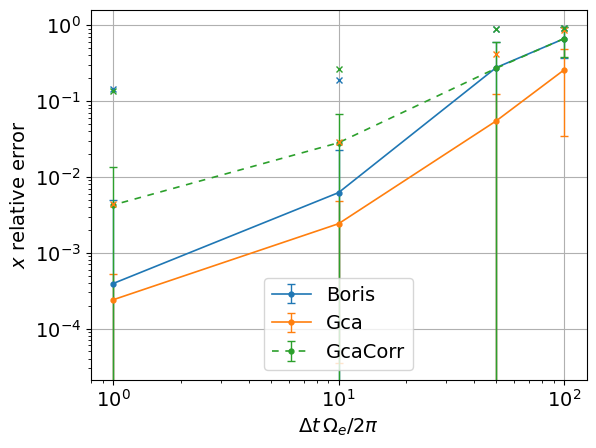

{'Boris': {'100': 878, '50': 413, '10': 17, '1': 0, '0_1': 0}, 'Gca': {'100': 319, '50': 5, '10': 0, '1': 0, '0_1': 0}, 'GcaCorr': {'100': 876, '50': 379, '10': 12, '1': 0, '0_1': 0}}


In [10]:
fig, ax, nan_counts, nan_lists = xRelErr(sim, baseline, particles=np.arange(1000), dtw_list=("100","50","10","1"), keepOutofBounds=True)
# ax.set_ylim(1e-5, 1e1)
plt.show()

print(nan_counts)


/home/exxxx5/osiris_utils/osiris_utils/data/diagnostic.py:313: UserWarning: Failed to read ndump from input deck. Defaulting to 1. Use "Diagnostic.dump = <value>" to set it.
  warnings.warn(f"Failed to read ndump from input deck. Defaulting to {self._ndump}. Use \"Diagnostic.dump = <value>\" to set it.")
Calculating Drifts: 100%|██████████| 1000/1000 [00:07<00:00, 129.73it/s]


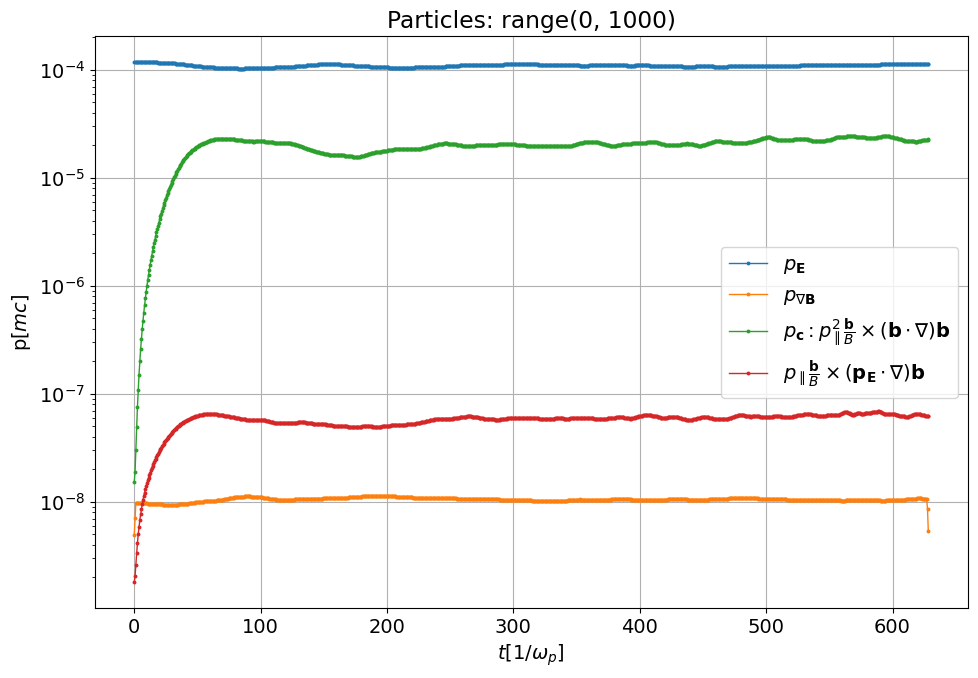

In [11]:
# Plot drifts over the trajectory
particle = range(0, 1000)
tmax = 7000000
rqm = -1

fig, ax = None, None                            
fig, ax = plot_drifts(baseline, particles=particle, tmax=tmax, fig=fig, ax=ax, n=5)

ax.grid()
# ax.set_yscale('log')
ax.set_title("Particles: " + str(particle))
ax.set_yscale('log')
plt.tight_layout()
plt.show()

## Bx100, Ex0

In [12]:
dtw = "0_01"
test = "NoE_FinalV"
# test = "OriginalParams_FinalV"
sim_labels = {
    'Boris': ["100", "50", "10", "1", "0_1"],
    'Gca': ["100", "50", "10", "1", "0_1"],
    'GcaCorr': ["100", "50", "10", "1", "0_1"],
}

# sametimeIter ={
#     "1000" : 10,
#     "100" : 100,
#     "10" : 1000,
#     "1" : 10000,
#     "0_1" : 10000,
# }

sim = createSimDic(sim_labels, test)
baseline = ou.Simulation(f"/home/exxxx5/Tese/Decks/weibelTestsFinal/{test}/Boris/dtw{dtw}/Boris.in")
baseline["test_electrons"]["tracks"].load_all()

print("Check out of bounds particles:")
for pusher in sim.keys():
    for dtw in ["100", "50"]:
        if(check_out_bounds(sim[pusher][dtw]["test_electrons"]["tracks"])):
            print(f"  {pusher} dtw{dtw}: OUT OF BOUNDS PARTICLES DETECTED!")

Loading data from tracks file.
Check out of bounds particles:


In [13]:
nans = find_nans_2d(sim["Gca"]["100"]["test_electrons"]["tracks"]["x1"][:,:])

print(nans["rows"].shape)

(0,)


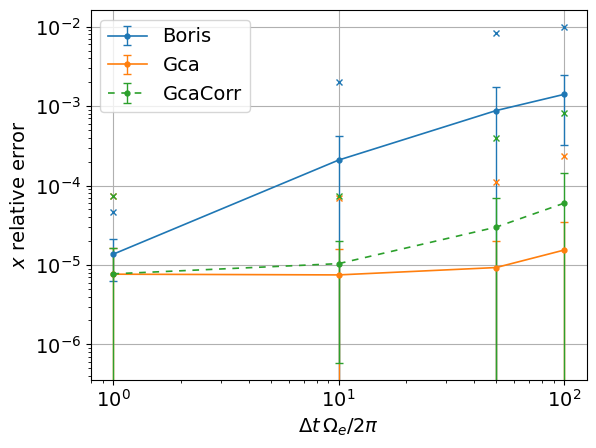

{'Boris': {'100': 0, '50': 0, '10': 0, '1': 0, '0_1': 0}, 'Gca': {'100': 0, '50': 0, '10': 0, '1': 0, '0_1': 0}, 'GcaCorr': {'100': 0, '50': 0, '10': 0, '1': 0, '0_1': 0}}


In [14]:
fig, ax, nan_counts, nan_lists = xRelErr(sim, baseline, particles=np.arange(1000), dtw_list=("100","50","10","1"), keepOutofBounds=True)
# ax.set_ylim(1e-5, 1e1)
plt.show()

print(nan_counts)


Calculating Drifts: 100%|██████████| 1000/1000 [00:04<00:00, 214.97it/s]


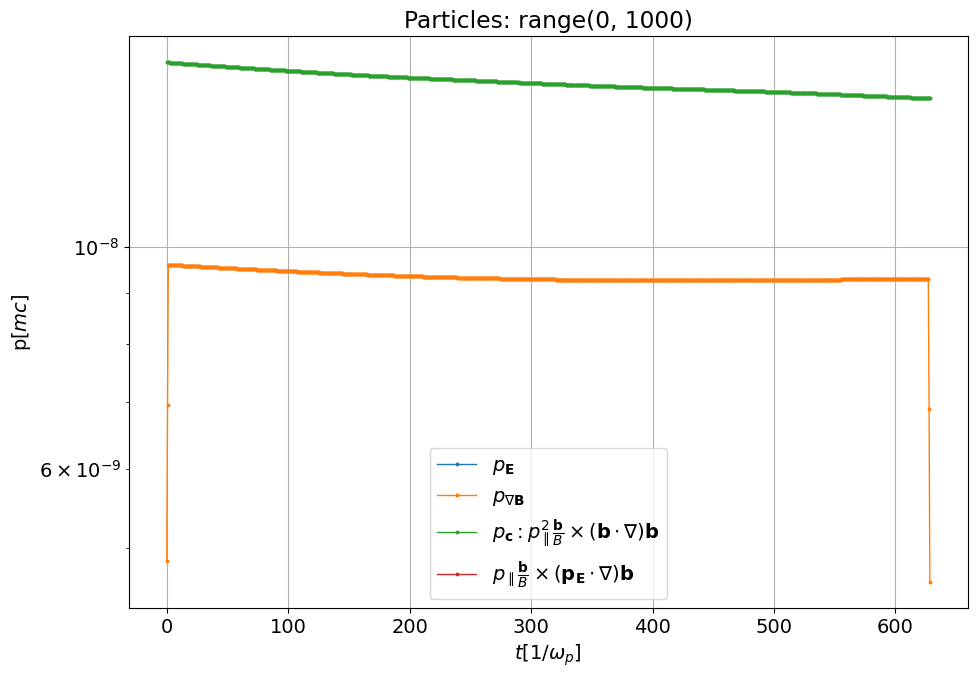

In [15]:
# Plot drifts over the trajectory
particle = range(0, 1000)
tmax = 7000000
rqm = -1

fig, ax = None, None                            
fig, ax = plot_drifts(baseline, particles=particle, tmax=tmax, fig=fig, ax=ax, n=5)

ax.grid()
# ax.set_yscale('log')
ax.set_title("Particles: " + str(particle))
ax.set_yscale('log')
plt.tight_layout()
plt.show()

## Bx100, Ex0.1, Lx10

In [16]:
dtw = "0_01"
test = "L400_FinalV"
# test = "OriginalParams_FinalV"
sim_labels = {
    'Boris': ["100", "50", "10", "1", "0_1"],
    'Gca': ["100", "50", "10", "1", "0_1"],
    'GcaCorr': ["100", "50", "10", "1", "0_1"],
}

# sametimeIter ={
#     "1000" : 10,
#     "100" : 100,
#     "10" : 1000,
#     "1" : 10000,
#     "0_1" : 10000,
# }

sim = createSimDic(sim_labels, test)
baseline = ou.Simulation(f"/home/exxxx5/Tese/Decks/weibelTestsFinal/{test}/Boris/dtw{dtw}/Boris.in")
baseline["test_electrons"]["tracks"].load_all()

print("Check out of bounds particles:")
for pusher in sim.keys():
    for dtw in ["100", "50"]:
        if(check_out_bounds(sim[pusher][dtw]["test_electrons"]["tracks"])):
            print(f"  {pusher} dtw{dtw}: OUT OF BOUNDS PARTICLES DETECTED!")

Loading data from tracks file.
Check out of bounds particles:
  GcaCorr dtw100: OUT OF BOUNDS PARTICLES DETECTED!


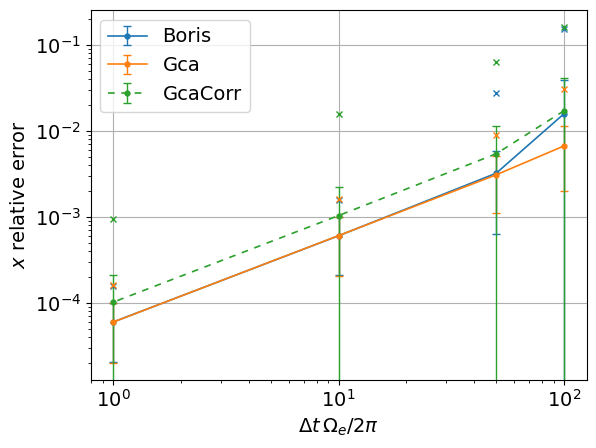

{'Boris': {'100': 0, '50': 0, '10': 0, '1': 0, '0_1': 0}, 'Gca': {'100': 0, '50': 0, '10': 0, '1': 0, '0_1': 0}, 'GcaCorr': {'100': 1, '50': 0, '10': 0, '1': 0, '0_1': 0}}


In [17]:
fig, ax, nan_counts, nan_lists = xRelErr(sim, baseline, particles=np.arange(1000), dtw_list=("100","50","10","1"), keepOutofBounds=True)
# ax.set_ylim(1e-5, 1e1)
plt.show()

print(nan_counts)


Calculating Drifts: 100%|██████████| 1000/1000 [00:04<00:00, 211.17it/s]


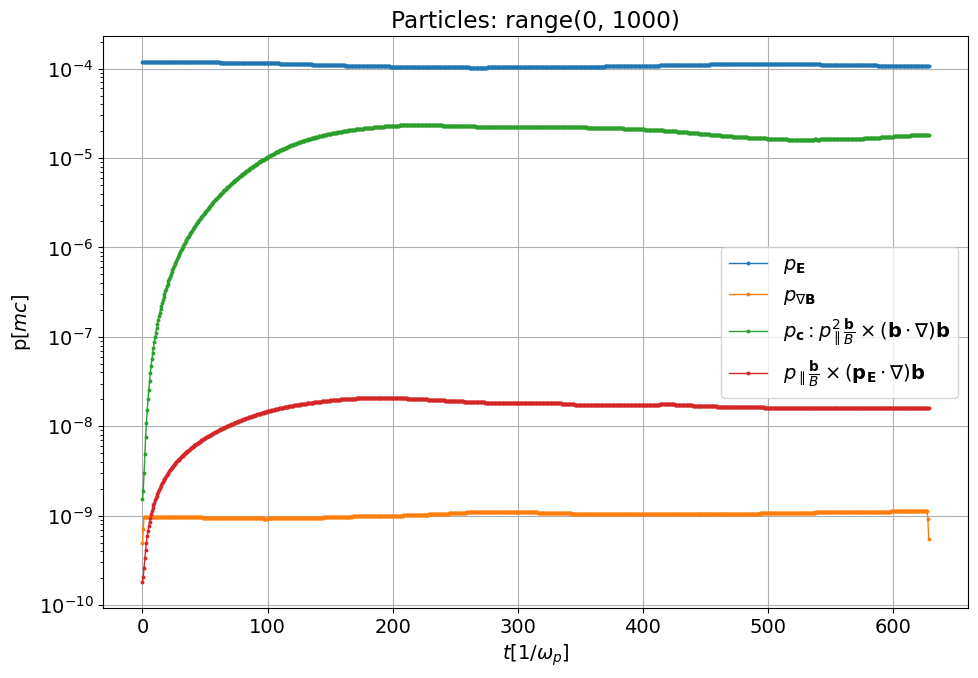

In [18]:
# Plot drifts over the trajectory
particle = range(0, 1000)
tmax = 7000000
rqm = -1

fig, ax = None, None                            
fig, ax = plot_drifts(baseline, particles=particle, tmax=tmax, fig=fig, ax=ax, n=5)

ax.grid()
# ax.set_yscale('log')
ax.set_title("Particles: " + str(particle))
ax.set_yscale('log')
plt.tight_layout()
plt.show()

## Bx100, Ex0, Lx10

In [19]:
dtw = "0_01"
# test = "NoE_FinalV"
test = "NoEL400_FinalV"
sim_labels = {
    'Boris': ["100", "50", "10", "1", "0_1"],
    'Gca': ["100", "50", "10", "1", "0_1"],
    'GcaCorr': ["100", "50", "10", "1", "0_1"],
}

# sametimeIter ={
#     "1000" : 10,
#     "100" : 100,
#     "10" : 1000,
#     "1" : 10000,
#     "0_1" : 10000,
# }

sim = createSimDic(sim_labels, test)
baseline = ou.Simulation(f"/home/exxxx5/Tese/Decks/weibelTestsFinal/{test}/Boris/dtw{dtw}/Boris.in")
baseline["test_electrons"]["tracks"].load_all()

print("Check out of bounds particles:")
for pusher in sim.keys():
    for dtw in ["100", "50"]:
        if(check_out_bounds(sim[pusher][dtw]["test_electrons"]["tracks"])):
            print(f"  {pusher} dtw{dtw}: OUT OF BOUNDS PARTICLES DETECTED!")



Loading data from tracks file.
Check out of bounds particles:


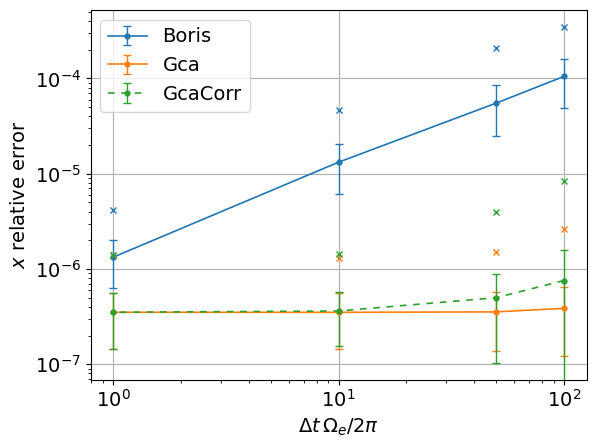

{'Boris': {'100': 0, '50': 0, '10': 0, '1': 0, '0_1': 0}, 'Gca': {'100': 0, '50': 0, '10': 0, '1': 0, '0_1': 0}, 'GcaCorr': {'100': 0, '50': 0, '10': 0, '1': 0, '0_1': 0}}


In [20]:
fig, ax, nan_counts, nan_lists = xRelErr(sim, baseline, particles=np.arange(1000), dtw_list=("100","50","10","1"), keepOutofBounds=True)
# ax.set_ylim(1e-5, 1e1)
plt.show()

print(nan_counts)

Calculating Drifts: 100%|██████████| 1000/1000 [00:04<00:00, 217.63it/s]


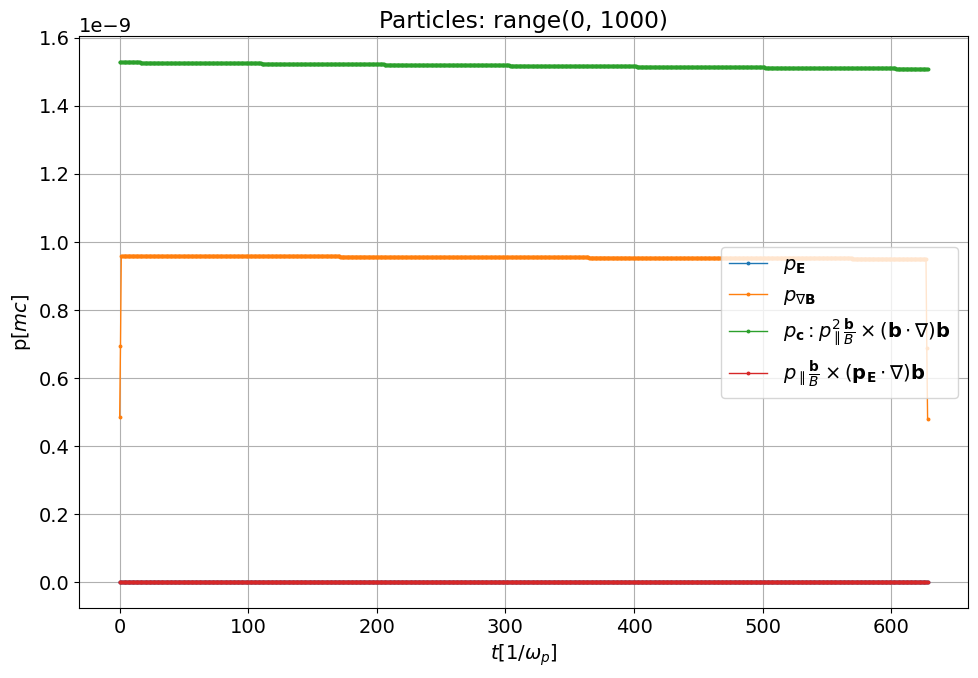

In [21]:
# Plot drifts over the trajectory
particle = range(0, 1000)
tmax = 7000000
rqm = -1

fig, ax = None, None                            
fig, ax = plot_drifts(baseline, particles=particle, tmax=tmax, fig=fig, ax=ax, n=5)

ax.grid()
# ax.set_yscale('log')
ax.set_title("Particles: " + str(particle))

plt.tight_layout()
plt.show()

## Bx100, Ex0.01

In [22]:
dtw = "0_01"
test = "E0_01_FinalV"
# test = "OriginalParams_FinalV"
sim_labels = {
    'Boris': ["100", "50", "10", "1", "0_1"],
    'Gca': ["100", "50", "10", "1", "0_1"],
    'GcaCorr': ["100", "50", "10", "1", "0_1"],
}

# sametimeIter ={
#     "1000" : 10,
#     "100" : 100,
#     "10" : 1000,
#     "1" : 10000,
#     "0_1" : 10000,
# }

sim = createSimDic(sim_labels, test)
baseline = ou.Simulation(f"/home/exxxx5/Tese/Decks/weibelTestsFinal/{test}/Boris/dtw{dtw}/Boris.in")
baseline["test_electrons"]["tracks"].load_all()

print("Check out of bounds particles:")
for pusher in sim.keys():
    for dtw in ["100", "50"]:
        if(check_out_bounds(sim[pusher][dtw]["test_electrons"]["tracks"])):
            print(f"  {pusher} dtw{dtw}: OUT OF BOUNDS PARTICLES DETECTED!")

Loading data from tracks file.
Check out of bounds particles:
  Boris dtw100: OUT OF BOUNDS PARTICLES DETECTED!
  GcaCorr dtw100: OUT OF BOUNDS PARTICLES DETECTED!


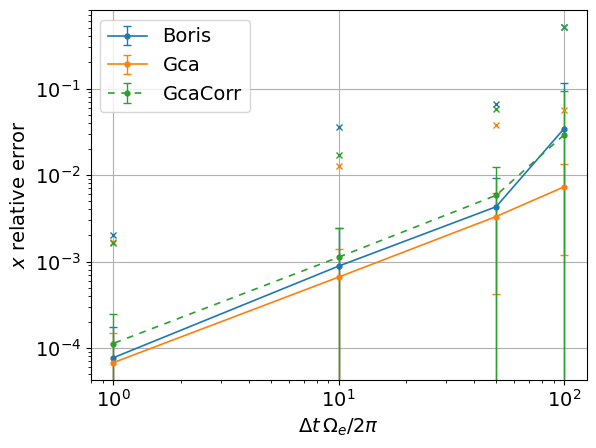

{'Boris': {'100': 72, '50': 0, '10': 0, '1': 0, '0_1': 0}, 'Gca': {'100': 0, '50': 0, '10': 0, '1': 0, '0_1': 0}, 'GcaCorr': {'100': 57, '50': 0, '10': 0, '1': 0, '0_1': 0}}


In [23]:
fig, ax, nan_counts, nan_lists = xRelErr(sim, baseline, particles=np.arange(1000), dtw_list=("100","50","10","1"), keepOutofBounds=True)
# ax.set_ylim(1e-5, 1e1)
plt.show()

print(nan_counts)

Calculating Drifts: 100%|██████████| 1000/1000 [00:04<00:00, 213.67it/s]


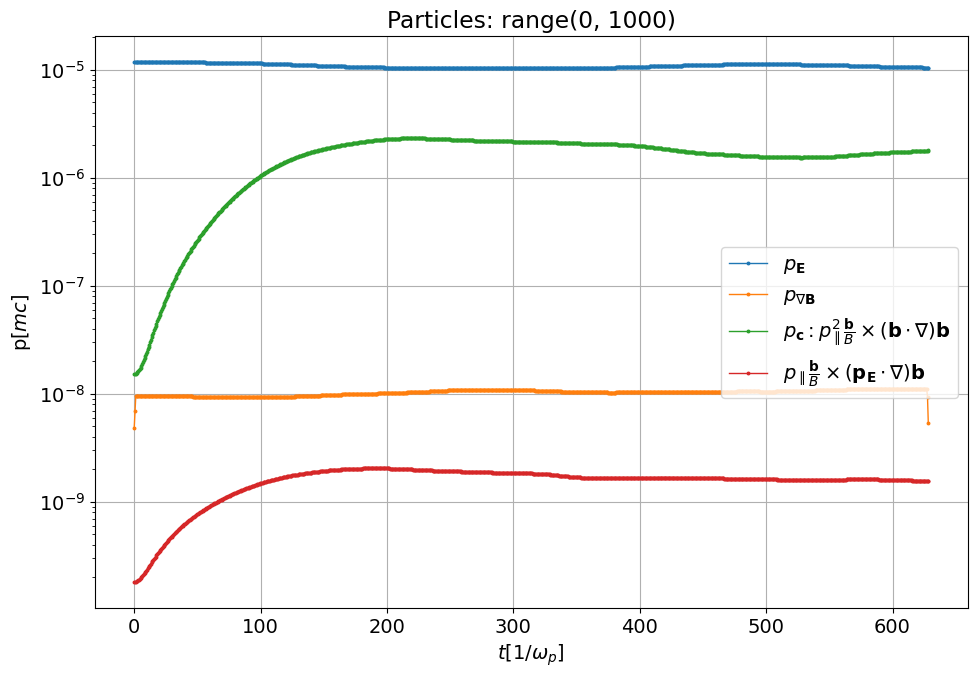

In [24]:
# Plot drifts over the trajectory
particle = range(0, 1000)
tmax = 7000000
rqm = -1

fig, ax = None, None                            
fig, ax = plot_drifts(baseline, particles=particle, tmax=tmax, fig=fig, ax=ax, n=5)

ax.grid()
ax.set_yscale('log')
ax.set_title("Particles: " + str(particle))

plt.tight_layout()
plt.show()

## Bx100, Ex0.01, Lx10

In [25]:
dtw = "0_01"
test = "E0_01L400_FinalV"
# test = "OriginalParams_FinalV"
sim_labels = {
    'Boris': ["100", "50", "10", "1", "0_1"],
    'Gca': ["100", "50", "10", "1", "0_1"],
    'GcaCorr': ["100", "50", "10", "1", "0_1"],
}

# sametimeIter ={
#     "1000" : 10,
#     "100" : 100,
#     "10" : 1000,
#     "1" : 10000,
#     "0_1" : 10000,
# }

sim = createSimDic(sim_labels, test)
baseline = ou.Simulation(f"/home/exxxx5/Tese/Decks/weibelTestsFinal/{test}/Boris/dtw{dtw}/Boris.in")
baseline["test_electrons"]["tracks"].load_all()

print("Check out of bounds particles:")
for pusher in sim.keys():
    for dtw in ["100", "50"]:
        if(check_out_bounds(sim[pusher][dtw]["test_electrons"]["tracks"])):
            print(f"  {pusher} dtw{dtw}: OUT OF BOUNDS PARTICLES DETECTED!")

Loading data from tracks file.
Check out of bounds particles:


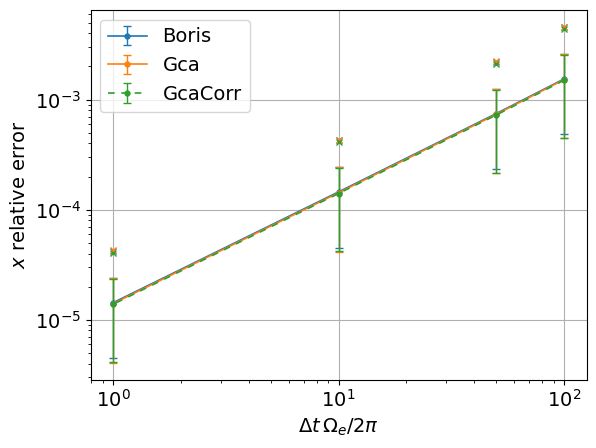

{'Boris': {'100': 0, '50': 0, '10': 0, '1': 0, '0_1': 0}, 'Gca': {'100': 0, '50': 0, '10': 0, '1': 0, '0_1': 0}, 'GcaCorr': {'100': 0, '50': 0, '10': 0, '1': 0, '0_1': 0}}


In [26]:
fig, ax, nan_counts, nan_lists = xRelErr(sim, baseline, particles=np.arange(1000), dtw_list=("100","50","10","1"), keepOutofBounds=True)
# ax.set_ylim(1e-5, 1e1)
plt.show()

print(nan_counts)

Calculating Drifts: 100%|██████████| 1000/1000 [00:04<00:00, 212.41it/s]


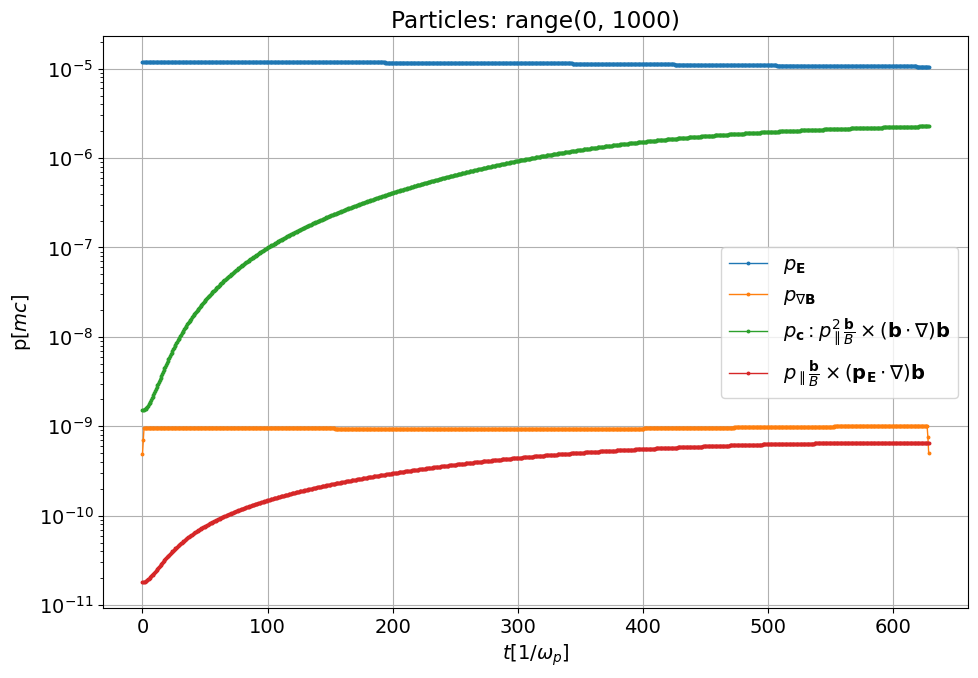

In [27]:
# Plot drifts over the trajectory
particle = range(0, 1000)
tmax = 7000000
rqm = -1

fig, ax = None, None                            
fig, ax = plot_drifts(baseline, particles=particle, tmax=tmax, fig=fig, ax=ax, n=5)

ax.grid()
ax.set_yscale('log')
ax.set_title("Particles: " + str(particle))

plt.tight_layout()
plt.show()